In [1]:
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import vice

from astropy.table import Table
import astropy as ap
import astropy.units as u

import surp

/astro/dboyea/.local/lib/python3.11/site-packages/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [2]:
surp.yields.set_magg22_scale()

yields set to Magg et al. 2022 abundances


In [3]:
filename = "../../data/allStar-dr17-synspec_rev1.fits"



In [24]:
ff = fits.open(filename)

In [23]:
elem_props = Table.read(filename, format="fits", hdu=3, memmap=True)

In [21]:
elem_props

WAVE,PARAM_SYMBOL,ELEM_SYMBOL,ELEMTOH,ELEM_VALUE,GRIDS
float32[7514],bytes64[9],bytes20[27],int32[27],bytes48[27],bytes20[21]
15152.211 .. 16943.533,TEFF .. PARAM_O,C .. C13,0 .. 0,C_FE .. C13_FE,BA .. Fd_d


In [5]:
for i in range(27):
    print(elem_props["ELEM_SYMBOL"][i], "\t", elem_props["DWARF_SOLARNEIGH_ZERO"][i], " +- ", elem_props["DWARF_SOLARNEIGH_ZERO_ERR"][i], "\t", elem_props["SOLAR_ZERO"][i])

KeyError: 'DWARF_SOLARNEIGH_ZERO'

In [7]:
for i in range(27):
    print(elem_props["ELEM_SYMBOL"][i], "\t", elem_props["GIANT_SOLARNEIGH_ZERO"][i], " +- ", elem_props["GIANT_SOLARNEIGH_ZERO_ERR"][i], "\t", elem_props["SOLAR_ZERO"][i])

KeyError: 'GIANT_SOLARNEIGH_ZERO'

In [9]:
allStar = Table.read(filename, format="fits", hdu=1, memmap=True)

In [10]:
filename = "../../data/apogee_astroNN-DR17.fits"
astroNN = Table.read(filename, format="fits", memmap=True)

In [11]:
ann = astroNN.to_pandas()

In [12]:
ann.drop_duplicates("APOGEE_ID", inplace=True)

In [13]:
ann.set_index("APOGEE_ID", inplace=True)

remove stars with
- STAR_BAD
- NO_ASPCAP_RESULT
- EXTRATARG=0

- R=3-13kpc
- |Z| < 2kpc
- -0.75 < Mg/H < 0.45
- S/N > 200 and Mg/H > -0.5
- SN ? 100 otherwise
- log g = 1-2.5
- Teff = 4000-4600

In [14]:
apogee_aspcapflag = 1<<23 # starbad
apogee_aspcapflag |= 1<<31 # no_aspcap_result

In [15]:
extratarg = 1<<0

In [16]:
extratarg

1

In [17]:
mask_extratarg_weak = (allStar["EXTRATARG"] & extratarg)  == 0


In [18]:
apogee_aspcapflag

2155872256

In [19]:
np.unique(allStar["ASPCAPFLAG"] & apogee_aspcapflag)

0
8388608
2155872256


In [20]:
mask_aspcap = (allStar["ASPCAPFLAG"] & apogee_aspcapflag) == 0
mask_extratarg = allStar["EXTRATARG"]  == 0


mask_fe_mg = allStar["FE_H_FLAG"] == 0
mask_fe_mg &= allStar["MG_FE_FLAG"] == 0

mask_fe_mg_2 = ~np.isnan(allStar["FE_H"])
mask_fe_mg_2 = ~np.isnan(allStar["MG_FE"])


In [21]:
np.sum(mask_fe_mg), np.sum(mask_fe_mg_2), np.sum(mask_fe_mg_2 & mask_fe_mg)

(666956, 646291, 633362)

In [22]:
np.sum(mask_fe_mg_2 & mask_fe_mg)

633362

In [23]:
ann_filt = np.isin(allStar["APOGEE_ID"], astroNN["APOGEE_ID"])

In [24]:
ann_match = ann.loc[allStar["APOGEE_ID"][ann_filt].value]

In [25]:
ann_match

,LOCATION_ID,TELESCOPE,RA_APOGEE,DEC_APOGEE,TEFF,TEFF_ERR,LOGG,LOGG_ERR,C_H,C_H_ERR,...,theta_phi,theta_phi_err,theta_z,theta_z_err,rl,rl_err,Energy,Energy_err,EminusEc,EminusEc_err
APOGEE_ID,,,,,,,,,,,,,,,,,,,,,
b'VESTA',1,b'apo1m',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b'2M00000002+7417074',5046,b'apo25m',0.000103,74.285408,3730.434814,49.411095,0.864455,0.091876,-0.151543,0.032733,...,0.162341,0.002044,1.257675,0.029077,9.313814,0.104881,-35566.630438,541.664052,-53127.445881,237.718629
b'2M00000019-1924498',5071,b'apo25m',0.000832,-19.413851,5517.530273,136.336548,4.045386,0.218193,-0.239434,0.041846,...,6.186121,0.014669,3.736751,0.015291,7.512346,0.151292,-44554.547150,644.013746,-56067.037371,67.716759
b'2M00000032+5737103',4424,b'apo25m',0.001335,57.619530,6120.589355,157.397263,3.726100,0.178082,-0.199688,0.034659,...,0.107626,0.000209,4.070717,0.015488,8.936393,0.004623,-38054.696452,22.626826,-54490.702876,8.455816
b'2M00000032+5737103',4424,b'apo25m',0.001335,57.619530,6120.589355,157.397263,3.726100,0.178082,-0.199688,0.034659,...,0.107626,0.000209,4.070717,0.015488,8.936393,0.004623,-38054.696452,22.626826,-54490.702876,8.455816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'2M23595886-2009435',5071,b'apo25m',359.995258,-20.162107,4385.419922,18.942038,1.607170,0.051512,-0.573421,0.042118,...,5.245957,0.035109,4.489594,0.019772,2.715510,0.173466,-26309.039393,1459.584798,-3208.330021,3927.172429
b'2M23595886+5726058',4424,b'apo25m',359.995265,57.434956,6205.649902,156.622910,4.093451,0.166493,-0.372012,0.037212,...,0.241518,0.001445,3.770612,0.034564,8.343132,0.059089,-40588.051794,297.780679,-55113.572201,98.472122
b'2M23595921+5609479',-999,b'apo25m',359.996744,56.163330,4981.779297,46.355877,3.056617,0.102835,-0.286302,0.041631,...,0.255623,0.002026,5.967744,0.008252,9.237442,0.083535,-36290.481852,387.265723,-53629.147394,141.979567


In [26]:
r = np.full(len(allStar), np.NaN)
r[ann_filt] = ann_match.galr


z = np.full(len(allStar), np.NaN)
z[ann_filt] = ann_match.galz

In [27]:
allStar["R_gal"] = r
allStar["z_gal"] = z

(array([   441.,    989.,   1270.,   1948.,   2056.,   1723.,   1853.,
          2166.,   1936.,   1873.,   2006.,   1928.,   1703.,   1931.,
          2307.,   1932.,   2060.,   2470.,   2492.,   2434.,   2956.,
          2876.,   3209.,   3428.,   3185.,   3060.,   3106.,   3265.,
          3360.,   3495.,   4391.,   5722.,   4817.,   5073.,   6275.,
          9457.,   9692.,  11445.,  20370.,  54968., 152807.,  83764.,
         43953.,  23150.,  16152.,  13963.,  12072.,  10735.,   9452.,
          8757.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
         2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
         4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,
         6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,
         8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. ]),
 <BarContainer object of 50 artists>)

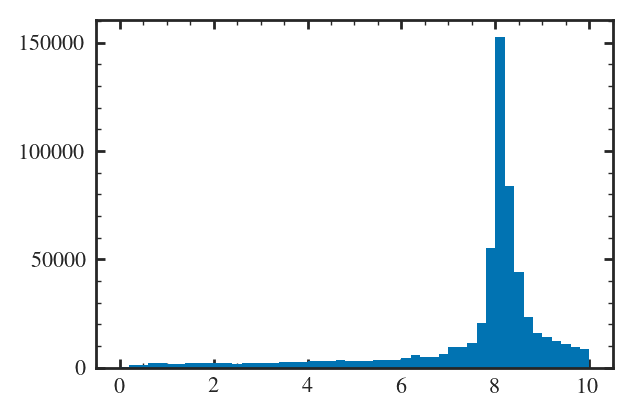

In [28]:
plt.hist(allStar["R_gal"], range=(0, 10))

(array([   178.,    140.,    164.,    184.,    173.,    186.,    230.,
           263.,    351.,    470.,    527.,    696.,    848.,   1177.,
          1496.,   2156.,   3004.,   4278.,   6250.,   8442.,  12530.,
         19211.,  35704.,  61016.,  99298., 125366.,  98896.,  55906.,
         35243.,  20598.,  13785.,  10363.,   7351.,   5396.,   4324.,
          3268.,   2542.,   1880.,   1494.,   1202.,    966.,    891.,
           721.,    610.,    530.,    439.,    449.,    383.,    367.,
           330.]),
 array([-5. , -4.8, -4.6, -4.4, -4.2, -4. , -3.8, -3.6, -3.4, -3.2, -3. ,
        -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8,
        -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,
         1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,
         3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ]),
 <BarContainer object of 50 artists>)

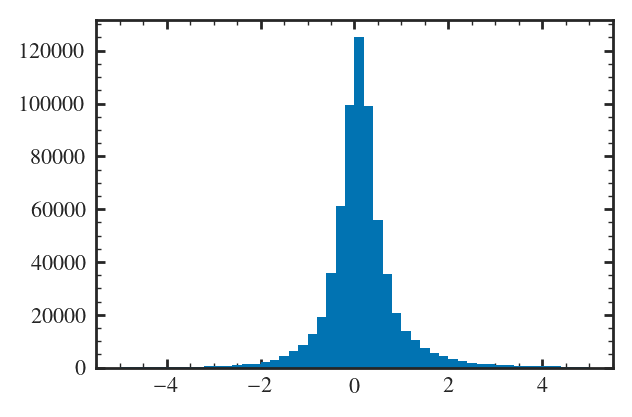

In [29]:
plt.hist(allStar["z_gal"], range=(-5, 5))

In [30]:
mask_zr = np.abs(allStar["z_gal"]) <= 2
mask_zr &= allStar["R_gal"] >= 3
mask_zr &= allStar["R_gal"] <= 13
mask_zr |= np.isnan(allStar["R_gal"])
mask_zr |= np.isnan(allStar["z_gal"])

print(np.sum(mask_zr))


651546


In [31]:
print(np.sum(mask_zr &  mask_extratarg))
print(np.sum(mask_zr & mask_extratarg_weak) )
print(np.sum(mask_zr  & mask_fe_mg & mask_aspcap & mask_fe_mg_2 ))

326868
363469
557844


In [32]:
mask = mask_zr  & mask_fe_mg & mask_aspcap & mask_fe_mg_2 & mask_extratarg
print(np.sum(mask))

312425


In [33]:
mg_h = allStar["MG_FE"] + allStar["FE_H"]

mask_mh = -0.75 <= mg_h
mask_mh &= mg_h <= 0.45

np.sum(mask_mh)
mask &= mask_mh
np.sum(mask)

309402

In [34]:
mask_snr = allStar["SNR"] >= 100
mask_snr &= (mg_h < -0.5)  | (allStar["SNR"] >= 200)

mask &= mask_snr
np.sum(mask)

103473

In [35]:
mask_logg = allStar["LOGG"] >= 1
mask_logg &= allStar["LOGG"] <= 2.5
np.sum(mask_logg)

mask &= mask_logg
np.sum(mask)

47221

In [36]:
mask_teff = allStar["TEFF"] <= 4600
mask_teff &= allStar["TEFF"] >= 4000

mask &= mask_teff
np.sum(mask)

25891

In [37]:
filtered = allStar[mask]

In [38]:
len(filtered)

25891

APOGEE CORRECTIONS
$$
{[{\rm{X}}/{\rm{H}}]}_{\mathrm{corr}}={[{\rm{X}}/{\rm{H}}]}_{\mathrm{APO}}+\mathrm{Offset}+{\alpha }_{T}({T}_{\mathrm{eff}}-4300)/100.
$$

Table 1 
Zero-point Offsets and T _eff Trend Slopes


| Elem.  |   Offset  |   10^3alpha_T  |
| -----  |    -----  |    ---------   |
| Mg     | 0.000     | 0.94           |
| O      | -0.016    |  2.28          |
| Si     | 0.038     | -3.22          |
| S      | 0.008     | 5.29           |
| Ca     | 0.071     | -6.01          |
| C+N    | 0.022     | 4.12           |
| Na     | 0.043     | 8.89           |
| Al     | 0.050     | -12.3          |
| K      | 0.002     | 1.68           |
| Cr     | 0.048     | 4.35           |
| Fe     | 0.053     | 0.76           |
| Ni     | 0.030     | 1.33           |
| V      | 0.222     | 14.9           |
| Mn     | 0.002     | 16.3           |
| Co     | -0.032    |  8.86          |
| Ce     | 0.125     | -2.64          |


In [39]:
def correct(df, col, offset, alpha3):
    new = df[col] + offset + alpha3*1e-3*(df["TEFF"] - 3400)/100
    
    print(np.mean(new - df[col]))
    df[col] = new

In [40]:
names = [name for name in filtered.colnames if len(filtered[name].shape) <= 1]


df1 = filtered[names].to_pandas()

df1["C_H"] = df1["C_FE"] + df1["FE_H"]
df1["N_H"] = df1["N_FE"] + df1["FE_H"]
df1["MG_H"] = df1["MG_FE"] + df1["FE_H"]

df1["CPN_H"] =  surp.gce_math.cpn(df1.C_H, df1.N_H)

correct(df1, "MG_H", 0, 0.94)
correct(df1, "FE_H", 0.053, 0.76)
correct(df1, "CPN_H", 0.022, 4.12)

0.008420365
0.059807956
0.05890581


In [41]:


df1["MG_FE"] = df1.MG_H - df1.FE_H
df1["C_MG"] = df1["C_H"] - df1["MG_H"]
df1["N_MG"] = df1["N_H"] - df1["MG_H"]


df1["high_alpha"] = surp.gce_math.is_high_alpha(df1["MG_FE"], df1["FE_H"])

df1.to_csv("../../data/apogee_cartography.csv")

In [22]:
df_lm = df1[(~df1.high_alpha) & (df1.MG_H < -0.3)]

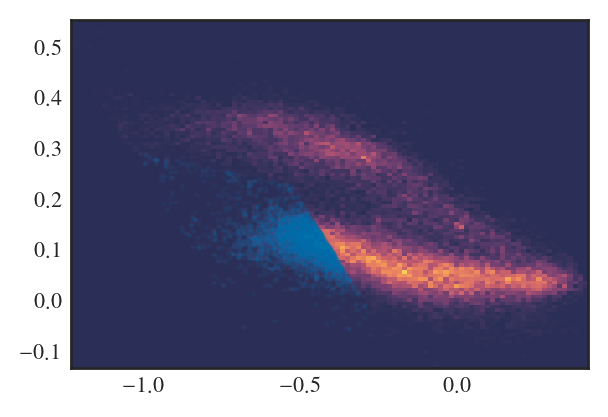

In [23]:
plt.hist2d(df1.FE_H, df1.MG_FE, 100);
plt.scatter(df_lm.FE_H, df_lm.MG_FE, s=0.3, alpha=0.1);

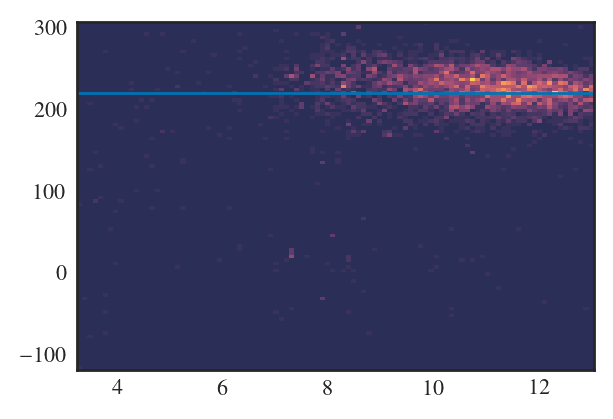

In [24]:
plt.hist2d(df_lm.R_gal, df_lm.vt_gal,bins=100);
plt.axhline(220)

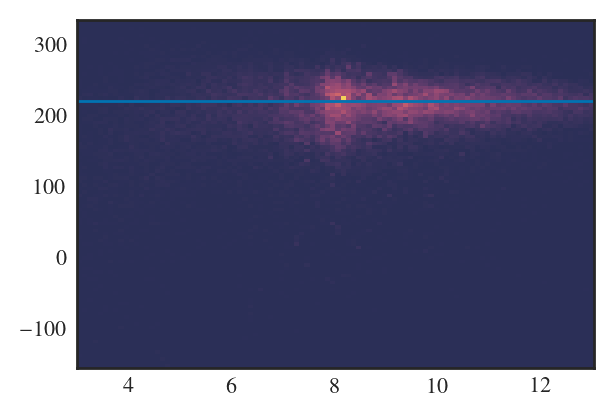

In [25]:
plt.hist2d(df1.R_gal, df1.vt_gal,bins=100);
plt.axhline(220)

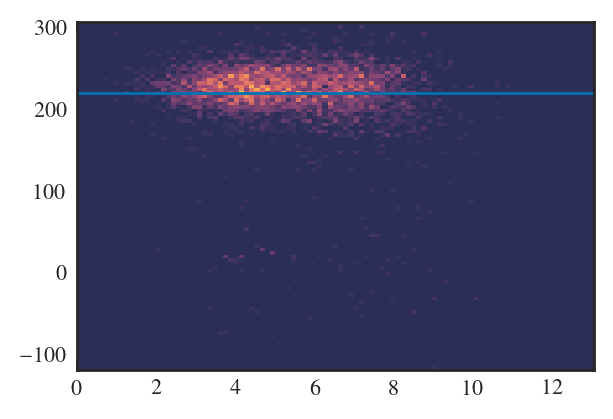

In [26]:
plt.hist2d(df_lm.age, df_lm.vt_gal, bins=(np.linspace(0, 13, 100), 100));
plt.axhline(220)

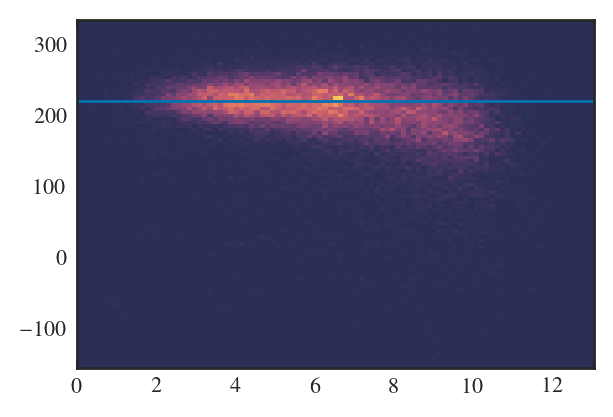

In [27]:
plt.hist2d(df1.age, df1.vt_gal, bins=(np.linspace(0, 13, 100), 100));
plt.axhline(220)

In [28]:
len(df1)

45453